In [14]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
def load_data(folder_path, data_type):        
    with open(folder_path + data_type + ".txt", 'r') as file:
        header_data = file.readlines()
        header_data = [line.strip() for line in header_data]
    if '3' in folder_path:
        return pd.DataFrame({'Header' : header_data})
    with open(folder_path + data_type + "-label.txt", 'r') as file:
        label_data = file.readlines()
        label_data = [line.strip() for line in label_data]    
    return pd.DataFrame({'Header' : header_data, 'Label' : label_data})

In [16]:
train_one = load_data("data/protocol1/", "train")
train_two = load_data("data/protocol2/", "train")
test_one = load_data("data/protocol1/", "test")
test_two = load_data("data/protocol2/", "test")
train_three = load_data("data/protocol3/", "train")

In [17]:
def get_byte_sequence(header_series):
    all_header_string = "".join(header_series.tolist())
    header_double_byte_list = [all_header_string[i:i+2] for i in range(0, len(all_header_string), 2)]
    return header_double_byte_list

def preprocess_data_array(data_array):
    data_hex_string_list = [header for header in data_array.to_list()]
    # print(data_hex_string_list)
    max_packet_length = max(len(header) for header in data_hex_string_list)
    # print(max_packet_length)
    data_bytes_padded_array = np.array([list(packet.ljust(max_packet_length, '0')) for packet in data_hex_string_list])
    # print(data_bytes_padded_array[0])
    data_double_bytes_array = np.array([list(''.join(packet[i:i+2]) for i in range(0, len(packet), 2)) for packet in data_bytes_padded_array])
    # print(data_double_bytes_array[0])

    # for i in range(data_double_bytes_array.shape[1]):
    #     print(len(np.unique(data_double_bytes_array[:, i])))
    # print(len(np.unique(data_double_bytes_array[:, 4])))

    data_bytes_array = np.vectorize(lambda x: int(x, 16))(data_double_bytes_array)
    # print(data_bytes_array[0])
    data_bytes_normalized_array = data_bytes_array / 255.0
    # print(data_bytes_normalized_array[0])
    # print(data_bytes_normalized_array.shape)
    last_non_zero_col = np.max(np.where(data_bytes_normalized_array != 0)[1])
    return data_bytes_normalized_array[:, :last_non_zero_col + 1]

train_bytes_normalized_array = preprocess_data_array(train_one["Header"])
print(train_bytes_normalized_array.shape)

(43345, 32)


In [18]:
def get_autoencoder(input_dim, latent_dim):
    
    # Encoder
    input_layer = Input(shape=(input_dim, ))
    if input_dim > 256:
        layer_sizes = [256, 64]
    elif input_dim in range(16, 64):
        layer_sizes = [16]
    
    # Small model with only one layer each for encoding and decoding (protocol-2)
    if input_dim < 16:
         encoded = Dense(latent_dim, activation='relu')(input_layer)
         decoded = Dense(input_dim, activation='sigmoid')(encoded)
    else: 
         # Encoder
         encoded = Dense(layer_sizes[0], activation='relu')(input_layer)
         encoded = BatchNormalization()(encoded)
         for size in layer_sizes[1:]:
             encoded = Dense(size, activation='relu')(encoded)
             encoded = BatchNormalization()(encoded)
         encoded = Dense(latent_dim, activation='relu')(encoded)
         # Decoder
         decoded = Dense(layer_sizes[-1], activation = 'relu')(encoded)
         decoded = BatchNormalization()(decoded)
         for size in layer_sizes[-2::-1]:
             decoded = Dense(size, activation='relu')(decoded)
             decoded = BatchNormalization()(decoded)
         decoded = Dense(input_dim, activation='sigmoid')(decoded)
    # Model
    autoencoder = Model(inputs = input_layer, outputs = decoded)
    # Compile
    autoencoder.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy')

    # Define Encoder
    encoder = Model(inputs = input_layer, outputs = encoded)

    # Define Decoder
    encoded_input = Input(shape=(latent_dim,))
    if input_dim < 16:
        decoded_output = autoencoder.layers[-1](encoded_input)
    else:
        layers = 2 * len(layer_sizes) + 1
        decoded_output = autoencoder.layers[-1 * layers](encoded_input)
        layers = layers - 1
        while(layers):
            decoded_output = autoencoder.layers[-1 * layers](decoded_output)
            layers = layers - 1

    decoder = Model(inputs=encoded_input, outputs=decoded_output)
    return autoencoder, encoder, decoder

1125/1125 [==============================] - 0s 169us/step
(35983, 10)
(35983, 10)


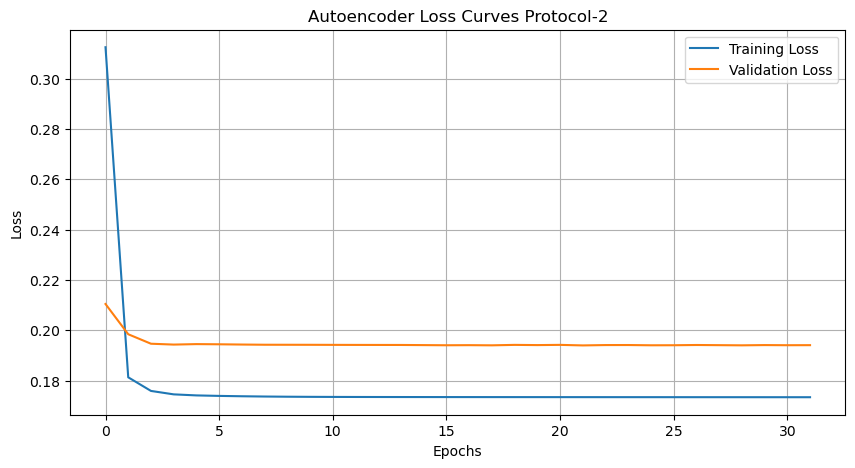

In [19]:
# Autoencoder to reduce dimensionality for non-linear packet header data

# 1. Load preprocessed 2D array of header data
train_bytes_normalized_array = preprocess_data_array(train_two["Header"])
test_bytes_normalized_array = preprocess_data_array(test_two["Header"])
# 2. Define train and test datasets
X_train, X_test = train_bytes_normalized_array, test_bytes_normalized_array
# X_train, X_test = train_test_split(train_bytes_normalized_array, test_size=0.2, random_state=0)
# 3. Get Autoencoder
input_dim = X_train.shape[1]
latent_dim = 10
autoencoder, encoder, decoder = get_autoencoder(input_dim, latent_dim)
# 4. Train the autoencoder
history = autoencoder.fit(X_train, X_train, 
                          epochs = 32, batch_size = 32, 
                          validation_data = (X_test, X_test), verbose = 0)
loss = autoencoder.evaluate(X_train, X_train)

# 5. Use the encoder to reduce dimensionality
latent_vectors = encoder.predict(X_train)


print(latent_vectors.shape)
print(latent_vectors.shape)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss Curves Protocol-2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [20]:
print(autoencoder.summary(), end="\n")


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_2 (Dense)             (None, 10)                130       
                                                                 
 dense_3 (Dense)             (None, 12)                132       
                                                                 
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________
None


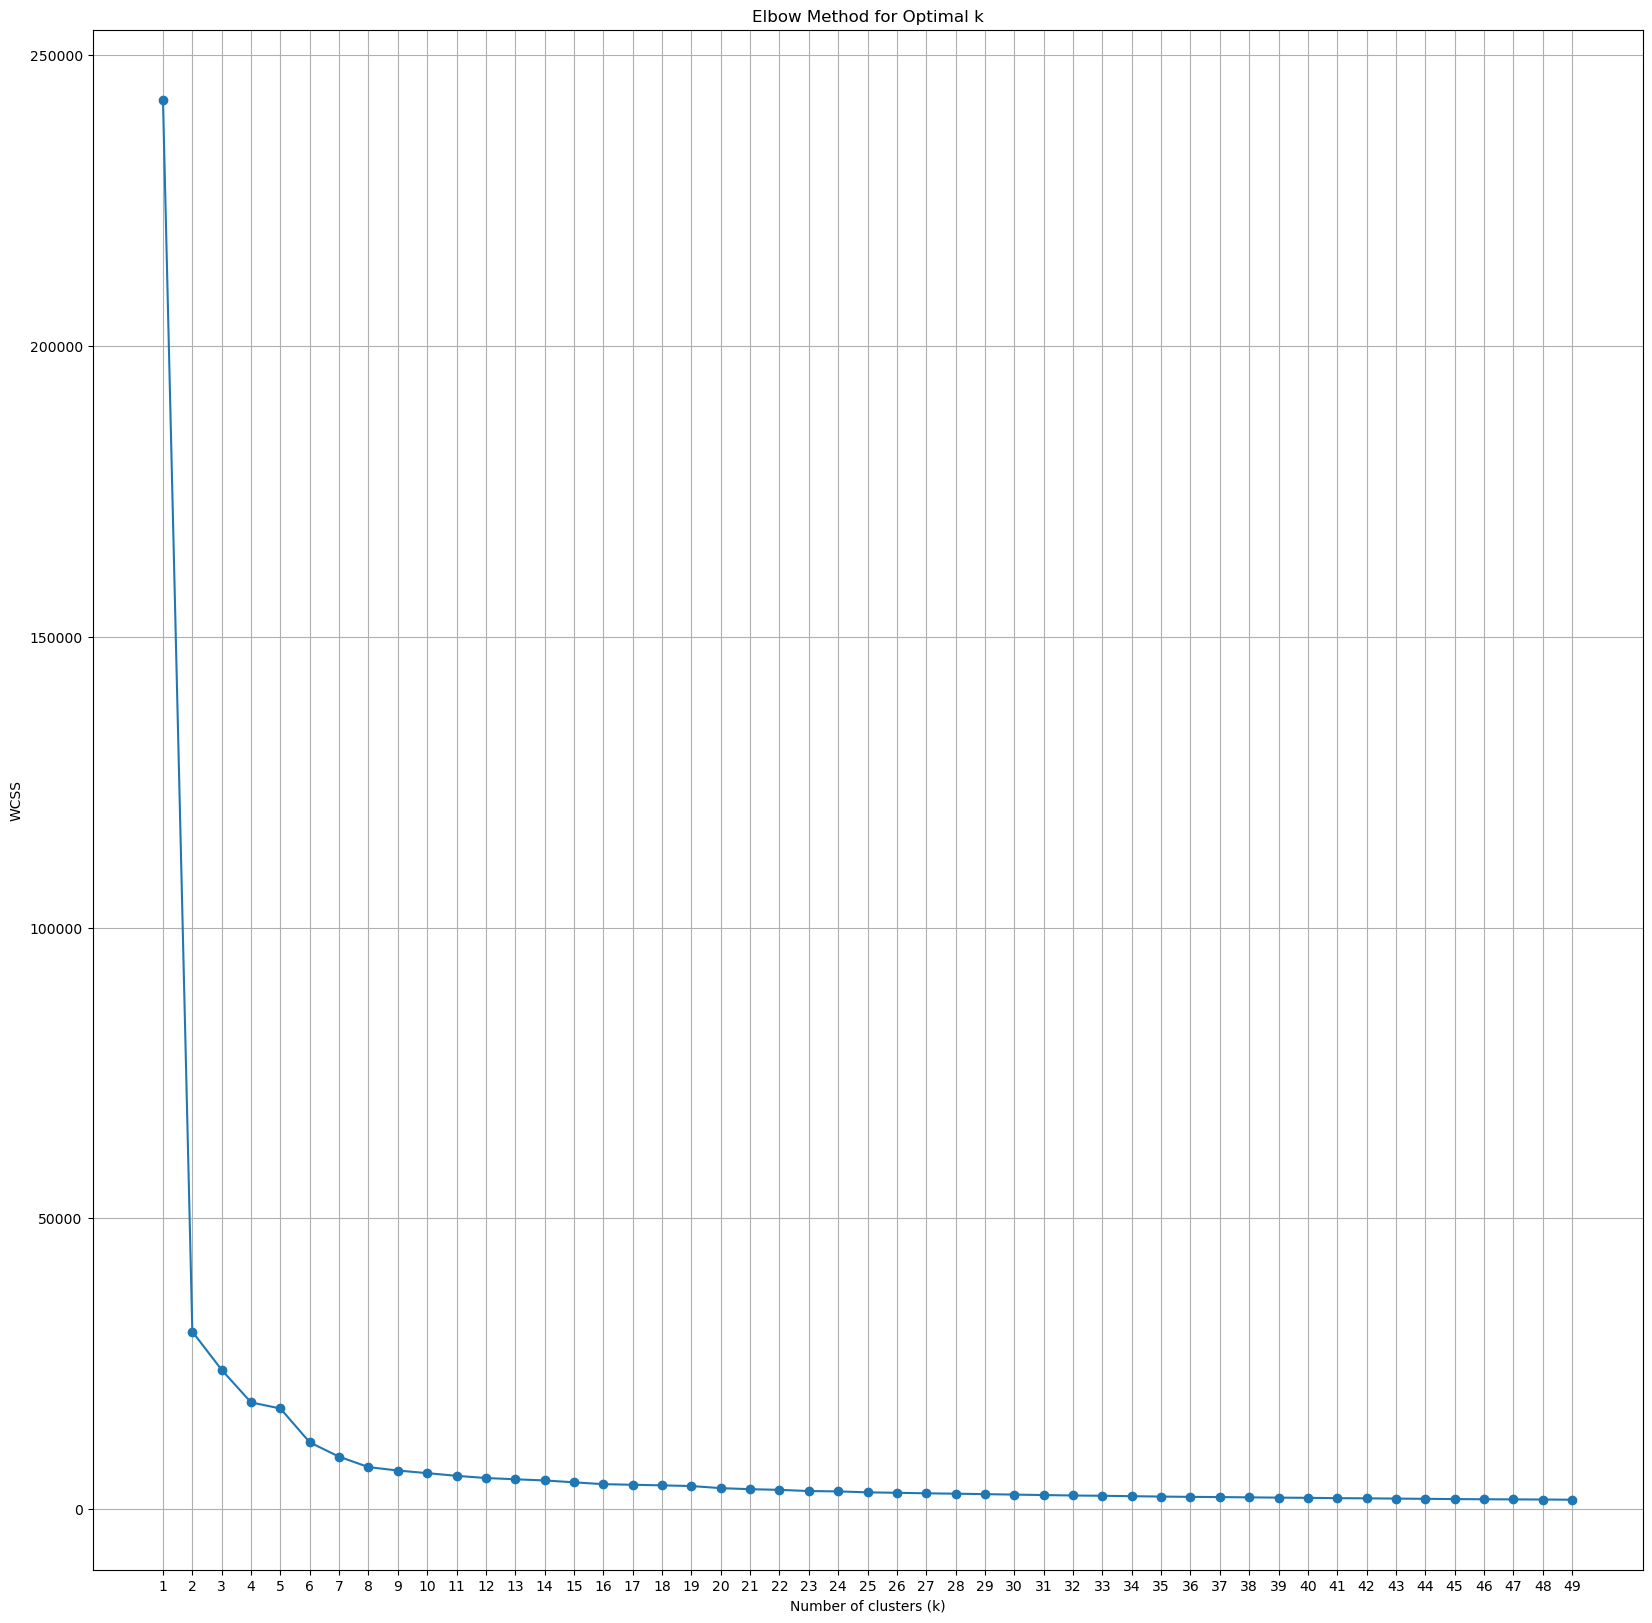

In [21]:
# Elbow method to find optimal k
wcss = []

# Range of k values to try
k_values = range(1, 50)

# Compute KMeans and WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(latent_vectors)
    wcss.append(kmeans.inertia_)  # inertia is WCSS

# Plotting the Elbow Method
plt.figure(figsize=(20, 20))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid()
plt.show()

In [27]:
kmeans = KMeans(n_clusters = 9, random_state = 0)
kmeans.fit(latent_vectors)
predicted_clusters = kmeans.labels_
predicted_centroids = kmeans.cluster_centers_
# print(type(predicted_clusters))
predicted_clusters = predicted_clusters[:, np.newaxis]
# print(predicted_clusters)
# print(predicted_clusters.shape, X_train.shape)
data_with_cluster_labels = np.hstack((predicted_clusters, X_train * 255)) 
# print(data_with_cluster_labels[:, 1:])
# print(data_with_cluster_labels.shape)

# Intra-cluster variance per byte
num_fields = X_train.shape[1]
num_clusters = len(np.unique(predicted_clusters))
intra_cluster_var = np.zeros((num_clusters, num_fields))

for cluster in range(num_clusters):
    cluster_data = data_with_cluster_labels[data_with_cluster_labels[:, 0] == cluster][:, 1:]
    intra_cluster_var[cluster] = np.var(cluster_data, axis = 0)
# print(intra_cluster_var.shape)
# print(intra_cluster_var)
intra_cluster_var[intra_cluster_var == 0] = 10 ** 10
# print(np.argmin(intra_cluster_var[:,4:], axis = 1))
# print(np.argsort(intra_cluster_var, axis = 1))

result_array = np.argsort(intra_cluster_var, axis = 1)
print("\n Protocol-2 Intra Cluster Variance (10 Least) : \n")
print(result_array)
unique_values, counts = np.unique(result_array[:, :1], return_counts=True)
print("\n Predicted Msg-type index: ", unique_values[np.argsort(counts)[-1]])

# print(intra_cluster_var)


# predict centroid in actual input space
centroid_data = decoder.predict(predicted_centroids, verbose = 0)

# Inter-cluster variance per byte
inter_cluster_var = np.var(centroid_data, axis = 0)
# print(centroid_data.shape)
# print(inter_cluster_var.shape)
# print(np.argmax(inter_cluster_var))
# print(np.argsort(inter_cluster_var))



 Protocol-2 Intra Cluster Variance (10 Least) : 

[[ 7  0  1  2  3  4  5  6  8  9 10 11]
 [ 7  8 11  0  1  9  2  3  4  5  6 10]
 [ 7  8 11  0  1  9  2  3  4  5  6 10]
 [ 7  0  1  2  3  4  5  6  8  9 10 11]
 [10  1 11  5  6  8  7  9  0  2  3  4]
 [ 7  8 11  0  1  9  2  3  4  5  6 10]
 [ 7  8 11  0  1  9  2  3  4  5  6 10]
 [ 7  0  1  2  3  4  5  6  8  9 10 11]
 [ 7  8 11  0  1  9  2  3  4  5  6 10]]

 Predicted Msg-type index:  7
